In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import imageio

config = tf.ConfigProto(gpu_options=tf.GPUOptions(visible_device_list="2", allow_growth=True))

#size of dynamic sinogram 
sino_size = [182, 182, 30]
sn_size = 182*182

#size of dynamic PET
I1 = 128
I2 = 128
T  = 30

# Load data
lmat = scipy.io.loadmat('simulation_data_SN20.mat')
Y = lmat['sinogram_noisy'] # Sinogram matrix with Poisson noise (SNR=20dB), size = (182*182, 30)
P = lmat['PET_image'] # True dynamic PET image matrix, size = (128*128, 30)
R = lmat['R'] # Radon transform matrix (P in the paper), size = (182*182, 128*128)

# define Radon transform matrix as SparseTensor for TensorFlow
coo = R.tocoo()
indices = np.mat([coo.row, coo.col]).transpose()
Rtf = tf.SparseTensor(indices, coo.data.astype(np.float32), coo.shape)

# Load smoothing matrix (H=L'L in the paper)
lmat = scipy.io.loadmat('smoothing_matrix.mat')
H = lmat['H']
H = H.astype('float32')


In [2]:
# Function definitions

# Define Unet for deep image prior
pad_para = [[0,0],[1,1],[1,1],[0,0]]
pad_type = 'reflect'

FS = [128]*5

kd = 3
ks = 1
ku = 3

def Unet(data, train=False):
    d1 = tf.pad(data, pad_para, pad_type)
    #d1 = tf.pad(d1, pad_para, pad_type)
    d1 = tf.layers.conv2d(d1,filters=FS[0],kernel_size=[kd,kd],padding="valid",strides=(2,2))
    d1 = tf.layers.batch_normalization(d1, training=train)
    d1 = tf.nn.leaky_relu(d1)
    d1 = tf.pad(d1, pad_para, pad_type)
    d1 = tf.layers.conv2d(d1,filters=FS[0],kernel_size=[kd,kd],padding="valid",strides=(1,1))
    d1 = tf.layers.batch_normalization(d1, training=train)
    d1 = tf.nn.leaky_relu(d1)
    s1 = tf.layers.conv2d(d1,filters=4,kernel_size=[ks,ks],padding="same",strides=(1,1))
    s1 = tf.layers.batch_normalization(s1)
    s1 = tf.nn.leaky_relu(s1)
    d2 = tf.pad(d1, pad_para, pad_type)
    d2 = tf.layers.conv2d(d2,filters=FS[1],kernel_size=[kd,kd],padding="valid",strides=(2,2))
    d2 = tf.layers.batch_normalization(d2, training=train)
    d2 = tf.nn.leaky_relu(d2)
    d2 = tf.pad(d2, pad_para, pad_type)
    d2 = tf.layers.conv2d(d2,filters=FS[1],kernel_size=[kd,kd],padding="valid",strides=(1,1))
    d2 = tf.layers.batch_normalization(d2, training=train)
    d2 = tf.nn.leaky_relu(d2)
    s2 = tf.layers.conv2d(d2,filters=4,kernel_size=[ks,ks],padding="same",strides=(1,1))
    s2 = tf.layers.batch_normalization(s2, training=train)
    s2 = tf.nn.leaky_relu(s2)
    d3 = tf.pad(d2, pad_para, pad_type)
    d3 = tf.layers.conv2d(d3,filters=FS[2],kernel_size=[kd,kd],padding="valid",strides=(2,2))
    d3 = tf.layers.batch_normalization(d3, training=train)
    d3 = tf.nn.leaky_relu(d3)
    d3 = tf.pad(d3, pad_para, pad_type)
    d3 = tf.layers.conv2d(d3,filters=FS[2],kernel_size=[kd,kd],padding="valid",strides=(1,1))
    d3 = tf.layers.batch_normalization(d3, training=train)
    d3 = tf.nn.leaky_relu(d3)
    s3 = tf.layers.conv2d(d3,filters=4,kernel_size=[ks,ks],padding="same",strides=(1,1))
    s3 = tf.layers.batch_normalization(s3, training=train)
    s3 = tf.nn.leaky_relu(s3)
    d4 = tf.pad(d3, pad_para, pad_type)
    d4 = tf.layers.conv2d(d4,filters=FS[3],kernel_size=[kd,kd],padding="valid",strides=(2,2))
    d4 = tf.layers.batch_normalization(d4, training=train)
    d4 = tf.nn.leaky_relu(d4)
    d4 = tf.pad(d4, pad_para, pad_type)
    d4 = tf.layers.conv2d(d4,filters=FS[3],kernel_size=[kd,kd],padding="valid",strides=(1,1))
    d4 = tf.layers.batch_normalization(d4, training=train)
    d4 = tf.nn.leaky_relu(d4)
    s4 = tf.layers.conv2d(d4,filters=4,kernel_size=[ks,ks],padding="same",strides=(1,1))
    s4 = tf.layers.batch_normalization(s4, training=train)
    s4 = tf.nn.leaky_relu(s4)
    d5 = tf.pad(d4, pad_para, pad_type)
    d5 = tf.layers.conv2d(d5,filters=FS[4],kernel_size=[kd,kd],padding="valid",strides=(2,2))
    d5 = tf.layers.batch_normalization(d5, training=train)
    d5 = tf.nn.leaky_relu(d5)
    d5 = tf.pad(d5, pad_para, pad_type)
    d5 = tf.layers.conv2d(d5,filters=FS[4],kernel_size=[kd,kd],padding="valid",strides=(1,1))
    d5 = tf.layers.batch_normalization(d5, training=train)
    d5 = tf.nn.leaky_relu(d5)
    s5 = tf.layers.conv2d(d5,filters=4,kernel_size=[ks,ks],padding="same",strides=(1,1))
    s5 = tf.layers.batch_normalization(s5, training=train)
    s5 = tf.nn.leaky_relu(s5)
    u4 = tf.concat([d5, s5],axis=3)
    u4 = tf.layers.batch_normalization(u4, training=train)
    u4 = tf.pad(u4, pad_para, pad_type)
    u4 = tf.layers.conv2d(u4,filters=FS[4],kernel_size=[ku,ku],padding="valid",strides=(1,1))
    u4 = tf.layers.batch_normalization(u4, training=train)    
    u4 = tf.nn.leaky_relu(u4)
    u4 = tf.layers.conv2d(u4,filters=FS[4],kernel_size=[1,1],padding="same",strides=(1,1))
    u4 = tf.layers.batch_normalization(u4, training=train)
    u4 = tf.nn.leaky_relu(u4)
    u4 = tf.image.resize_bilinear(u4,[u4.shape[1]*2, u4.shape[2]*2])
    u3 = tf.concat([u4, s4],axis=3)
    u3 = tf.layers.batch_normalization(u3, training=train)
    u3 = tf.pad(u3, pad_para, pad_type)
    u3 = tf.layers.conv2d(u3,filters=FS[3],kernel_size=[ku,ku],padding="valid",strides=(1,1))
    u3 = tf.layers.batch_normalization(u3, training=train)
    u3 = tf.nn.leaky_relu(u3)
    u3 = tf.layers.conv2d(u3,filters=FS[3],kernel_size=[1,1],padding="same",strides=(1,1))
    u3 = tf.layers.batch_normalization(u3, training=train)
    u3 = tf.nn.leaky_relu(u3)
    u3 = tf.image.resize_bilinear(u3,[u3.shape[1]*2, u3.shape[2]*2])
    u2 = tf.concat([u3, s3],axis=3)
    u2 = tf.layers.batch_normalization(u2, training=train)
    u2 = tf.pad(u2, pad_para, pad_type)
    u2 = tf.layers.conv2d(u2,filters=FS[2],kernel_size=[ku,ku],padding="valid",strides=(1,1))
    u2 = tf.layers.batch_normalization(u2, training=train)
    u2 = tf.nn.leaky_relu(u2)
    u2 = tf.layers.conv2d(u2,filters=FS[2],kernel_size=[1,1],padding="same",strides=(1,1))
    u2 = tf.layers.batch_normalization(u2, training=train)
    u2 = tf.nn.leaky_relu(u2)
    u2 = tf.image.resize_bilinear(u2,[u2.shape[1]*2, u2.shape[2]*2])
    u1 = tf.concat([u2, s2],axis=3)
    u1 = tf.layers.batch_normalization(u1, training=train)
    u1 = tf.pad(u1, pad_para, pad_type)
    u1 = tf.layers.conv2d(u1,filters=FS[1],kernel_size=[ku,ku],padding="valid",strides=(1,1))
    u1 = tf.layers.batch_normalization(u1, training=train)
    u1 = tf.nn.leaky_relu(u1)
    u1 = tf.layers.conv2d(u1,filters=FS[1],kernel_size=[1,1],padding="same",strides=(1,1))
    u1 = tf.layers.batch_normalization(u1, training=train)
    u1 = tf.nn.leaky_relu(u1)
    u1 = tf.image.resize_bilinear(u1,[u1.shape[1]*2, u1.shape[2]*2])
    u0 = tf.concat([u1, s1],axis=3)
    u0 = tf.layers.batch_normalization(u0, training=train)
    u0 = tf.pad(u0, pad_para, pad_type)
    u0 = tf.layers.conv2d(u0,filters=FS[0],kernel_size=[ku,ku],padding="valid",strides=(1,1))
    u0 = tf.layers.batch_normalization(u0, training=train)
    u0 = tf.nn.leaky_relu(u0)
    u0 = tf.layers.conv2d(u0,filters=FS[0],kernel_size=[1,1],padding="same",strides=(1,1))
    u0 = tf.layers.batch_normalization(u0, training=train)
    u0 = tf.nn.leaky_relu(u0)
    out = tf.image.resize_bilinear(u0,[u0.shape[1]*2, u0.shape[2]*2])
    out = tf.pad(out, pad_para, pad_type)
    out = tf.layers.conv2d(out,filters=FS[0],kernel_size=[ku,ku],padding="valid",strides=(1,1))
    out = tf.layers.batch_normalization(out, training=train)
    out = tf.nn.leaky_relu(out)
    out = tf.layers.conv2d(out,filters=FS[0],kernel_size=[1,1],padding="same",strides=(1,1))
    out = tf.layers.batch_normalization(out, training=train)
    out = tf.nn.leaky_relu(out)
    out = tf.layers.conv2d(out,filters=1,kernel_size=[1,1],padding="same",strides=(1,1))
    return tf.nn.sigmoid(out)

# Define KL divergence
def kl_divergence(p, q):
    return tf.reduce_sum(q - p*tf.log(q))

# Define quadratic variation penalty for smooth temporal bases
def QVnorm(Xs,Hs):
    return tf.trace(tf.matmul(tf.matmul(Xs,Hs),Xs,transpose_b=True))

# Update operation for smooth temporal bases (X = B' in paper)
ONE = np.ones((sn_size,T), dtype='float32')
def update_X(Xs,Ys,As,Hs,x_rate):
    top = tf.maximum(tf.matmul(As ,tf.divide(tf.maximum(Ys,1e-10),tf.maximum(tf.matmul(As,Xs),1e-10) ), transpose_a=True), 0.0) + tf.maximum(-tf.matmul(Xs,Hs),0.0) + 1e-5
    bot = tf.maximum(tf.matmul(As ,ONE, transpose_a=True), 0.0 ) + tf.maximum(tf.matmul(Xs,Hs),0.0) + 1e-5
    mul = tf.pow(tf.divide(top,bot),x_rate)
    return tf.maximum(tf.multiply(Xs,mul),1e-5)
    




In [3]:
import time
import random
import imageio
import numpy.matlib

# Probrem definitions
BATCH_SIZE = 1
train_size = 1
test_size  = 1

code_depth = 32

# placeholder of input noise of Unet
train_data_node  = tf.placeholder(tf.float32,shape=(BATCH_SIZE,I1,I2,code_depth))

# placeholder of observed noisy Sinogram
train_labels_node = tf.placeholder(tf.float32,shape=(sn_size,T))# placeholder of observed noisy Sinogram

# constant value of KL divergence
Y = np.maximum(Y,1e-10)
klc = np.sum((Y * np.log(Y)) - Y)

# Generated model of reconstructed sinogram
r = 3 # number of spatio-temporal bases (rank of NMF)
X_node  = tf.placeholder(tf.float32,shape=(r,T))
RA_node = tf.placeholder(tf.float32,shape=(sn_size,r))
H_node  = tf.placeholder(tf.float32,shape=(T,T))
x_rate_node = tf.placeholder(tf.float32,shape=())
X = update_X(X_node,train_labels_node,RA_node,H_node,x_rate_node)

A = Unet(train_data_node, True)
for ri in range(r-1):
    A = tf.concat([A, Unet(train_data_node, True)],axis=3)
A   = tf.reshape(A,[128*128,r])
RA  = tf.sparse_tensor_dense_matmul(Rtf,A) + 1e-10
RAX = tf.matmul(RA,X_node) + 1e-10 # reconstructed sinogram


# Cost function
alpha = 0.01 # hyper parameter for exclusiveness penalty
beta  = 5.0  # hyper parameter for smoothness penalty

loss = klc + kl_divergence(train_labels_node,RAX)
lp   = alpha * tf.reduce_sum(tf.norm(A, axis=1, ord=0.5) ** 2)
qv   = QVnorm(X_node,H_node)
cost = loss + lp + 0.5*qv

# Optimizer setting
batch = tf.Variable(0)
learning_rate = tf.train.exponential_decay(
    0.01,                 # Base learning rate.
    batch*BATCH_SIZE,     # Current index into the dataset.
    100,                  # Decay step.
    0.98,                 # Decay rate.
    staircase=True)

optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost, global_step=batch)
init = tf.global_variables_initializer()

<IPython.core.display.Javascript object>


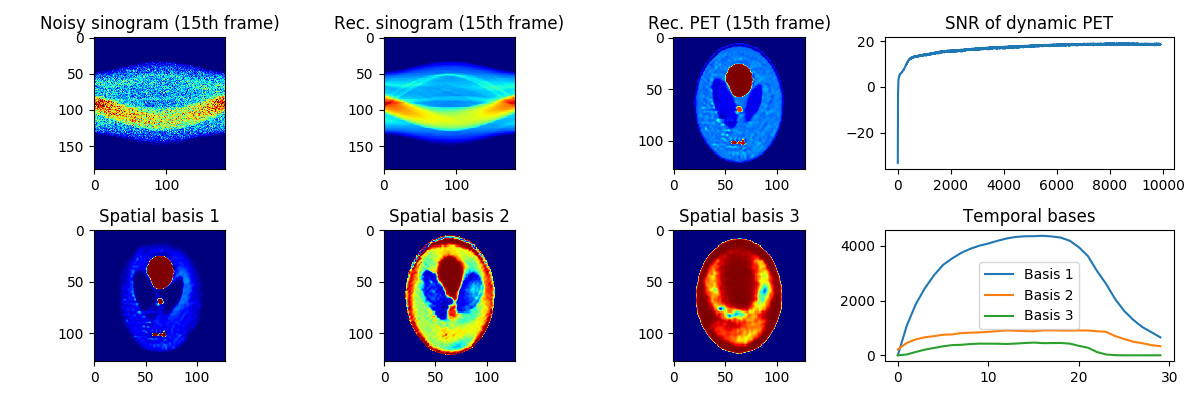

In [4]:
%matplotlib notebook

fig  = plt.figure(figsize=(12,4),dpi=100,tight_layout=True)
plt.rcParams["font.size"] = 10
ax241= fig.add_subplot(241)
ax242= fig.add_subplot(242)
ax243= fig.add_subplot(243)
ax244= fig.add_subplot(244)
ax245= fig.add_subplot(245)
ax246= fig.add_subplot(246)
ax247= fig.add_subplot(247)
ax248= fig.add_subplot(248)


In [5]:

# Start algorithm
num_iter = 10000
cost_hist = np.zeros([num_iter,3])
snr_hist  = np.zeros([num_iter,1])
start_time = time.time()

# Initialization
z = np.random.uniform(0.0,0.1,(1,I1,I2,32)) # input noise for Unet
z = z.astype('float32')
Xest = np.matlib.repmat(np.mean(Y, axis=0),r,1) + np.random.normal(0.0,1.0,(r,T))
Xest = Xest.astype('float32')
x_rate = 1.0

with tf.Session(config=config) as sess:
    sess.run(init)
    print('Iinitialized!')
    print('Iterations     :: Cost function    :: SNR value :: learning rate :: elapsed time :: x_rate ')
    for step in range(0,num_iter):
        noise = np.random.normal(0.0, 1.0/30.0,(1,I1,I2,32))# small noise for robust learning
        batch_data = z + noise
        batch_label= Y
        feed_dict = {train_data_node: batch_data,train_labels_node: batch_label, X_node:Xest, H_node:beta*H}
        # Update A
        _, cost_value, loss_value, lp_value, RAest, Aest = sess.run([optimizer, cost, loss, lp, RA, A], feed_dict)
        # Normalize A
        for ri in range(r):
            RAest[:,ri] = RAest[:,ri] / np.max(Aest[:,ri])
        # Update X (=B'), i_B = 10
        for nn in range(10):
            x_dict = {X_node:Xest, train_labels_node: batch_label, RA_node:RAest, H_node:beta*H, x_rate_node:x_rate}
            Xest2 = sess.run(X, x_dict)
            if np.max((Xest2/Xest)) > 1.1:
                x_rate = x_rate*0.1
            else:
                if np.min((Xest2/Xest)) < 0.9:
                    x_rate = x_rate*0.1
                else:
                    Xest=Xest2
        # Update learning rate
        l_rate = sess.run(learning_rate)
        # Record cost functions
        cost_hist[step,0] = cost_value
        cost_hist[step,1] = loss_value
        cost_hist[step,2] = lp_value
        # Evaluate denoising score (SNR)
        feed_dict_test = {train_data_node: z, train_labels_node: batch_label, X_node:Xest, RA_node:RAest, H_node:beta*H}
        Aest, RAXest, cost_value = sess.run([A,RAX,cost],feed_dict_test)
        AXest = np.matmul(Aest,Xest)
        snr_value = 10.0*np.log10(np.sum(P**2) / np.sum((P - AXest)**2))
        snr_hist[step,0] = snr_value
        # Show optimization behaviors
        if ((step < 100) & (step % 1 == 0)) | ((1000 > step > 100) & (step % 10 == 0)) | ((step > 1000) & (step % 100 == 0)):
            elapsed_time = time.time() - start_time
            start_time   = time.time()
            print('Step %d / %d :: %f :: %f :: %f :: %f :: %f ' % (step,num_iter,cost_value,snr_value,l_rate,elapsed_time,x_rate))
            ax245.clear()
            ax245.imshow(np.reshape(Aest[:,0],[128, 128]).T, cmap='jet', vmin=0.0, vmax=1.0)
            ax245.set_title("Spatial basis 1")
            ax246.clear()
            ax246.imshow(np.reshape(Aest[:,1],[128, 128]).T, cmap='jet', vmin=0.0, vmax=1.0)
            ax246.set_title("Spatial basis 2")
            ax247.clear()
            ax247.imshow(np.reshape(Aest[:,2],[128, 128]).T, cmap='jet', vmin=0.0, vmax=1.0)
            ax247.set_title("Spatial basis 3")
            ax248.clear()
            ax248.plot(Xest.T)
            ax248.legend(['Basis 1','Basis 2','Basis 3'])
            ax248.set_title("Temporal bases")
            ax243.clear()
            ax243.imshow(np.reshape(AXest[:,15],[128, 128]).T, cmap='jet')
            ax243.set_title("Rec. PET (15th frame)")
            ax242.clear()
            ax242.imshow(np.reshape(RAXest[:,15],[182, 182]).T, cmap='jet', vmin=0.0, vmax=350000.0)
            ax242.set_title("Rec. sinogram (15th frame)")
            ax241.clear()
            ax241.imshow(np.reshape(Y[:,15],[182, 182]).T, cmap='jet', vmin=0.0, vmax=350000.0)
            ax241.set_title("Noisy sinogram (15th frame)")
            ax244.clear()
            ax244.plot(snr_hist[0:step])
            ax244.set_title("SNR of dynamic PET")
            fig.canvas.draw()
    print('finished')





Iinitialized!
Iterations     :: Cost function    :: SNR value :: learning rate :: elapsed time :: x_rate 
Step 0 / 10000 :: 3446192996352.000000 :: -33.059870 :: 0.010000 :: 12.297357 :: 0.010000 
Step 1 / 10000 :: 1589909520384.000000 :: -26.967422 :: 0.010000 :: 0.491088 :: 0.010000 
Step 2 / 10000 :: 729367969792.000000 :: -21.742258 :: 0.010000 :: 0.523427 :: 0.010000 
Step 3 / 10000 :: 415019139072.000000 :: -18.266434 :: 0.010000 :: 0.512792 :: 0.010000 
Step 4 / 10000 :: 224385122304.000000 :: -14.563486 :: 0.010000 :: 0.524341 :: 0.010000 
Step 5 / 10000 :: 130285707264.000000 :: -11.684373 :: 0.010000 :: 0.492581 :: 0.010000 
Step 6 / 10000 :: 86970064896.000000 :: -9.299382 :: 0.010000 :: 0.489965 :: 0.010000 
Step 7 / 10000 :: 58897915904.000000 :: -6.865233 :: 0.010000 :: 0.484555 :: 0.010000 
Step 8 / 10000 :: 43080712192.000000 :: -4.822886 :: 0.010000 :: 0.502354 :: 0.010000 
Step 9 / 10000 :: 34389712896.000000 :: -3.267420 :: 0.010000 :: 0.534213 :: 0.010000 
Step 10 /

Step 94 / 10000 :: 4573840896.000000 :: 5.681310 :: 0.010000 :: 0.521790 :: 0.010000 
Step 95 / 10000 :: 4593262592.000000 :: 5.679707 :: 0.010000 :: 0.506671 :: 0.010000 
Step 96 / 10000 :: 4612980736.000000 :: 5.677383 :: 0.010000 :: 0.503789 :: 0.010000 
Step 97 / 10000 :: 4625730048.000000 :: 5.676250 :: 0.010000 :: 0.522792 :: 0.010000 
Step 98 / 10000 :: 4616391680.000000 :: 5.683867 :: 0.010000 :: 0.584118 :: 0.010000 
Step 99 / 10000 :: 4584543744.000000 :: 5.700046 :: 0.009800 :: 0.515688 :: 0.010000 
Step 110 / 10000 :: 4402982912.000000 :: 5.859753 :: 0.009800 :: 2.268672 :: 0.010000 
Step 120 / 10000 :: 4298114048.000000 :: 6.005913 :: 0.009800 :: 2.094043 :: 0.010000 
Step 130 / 10000 :: 4292631808.000000 :: 6.115768 :: 0.009800 :: 2.104700 :: 0.010000 
Step 140 / 10000 :: 4253323264.000000 :: 6.210224 :: 0.009800 :: 2.108660 :: 0.010000 
Step 150 / 10000 :: 4148810752.000000 :: 6.351421 :: 0.009800 :: 2.119302 :: 0.010000 
Step 160 / 10000 :: 4363998720.000000 :: 6.366390

Step 990 / 10000 :: 3101450496.000000 :: 14.023327 :: 0.008337 :: 2.002518 :: 0.010000 
Step 1100 / 10000 :: 3094435328.000000 :: 14.220597 :: 0.008007 :: 19.187515 :: 0.010000 
Step 1200 / 10000 :: 3093002752.000000 :: 14.278774 :: 0.007847 :: 17.443899 :: 0.010000 
Step 1300 / 10000 :: 3091046912.000000 :: 14.502176 :: 0.007690 :: 17.312780 :: 0.010000 
Step 1400 / 10000 :: 3082763008.000000 :: 14.831974 :: 0.007536 :: 17.496885 :: 0.010000 
Step 1500 / 10000 :: 3092453120.000000 :: 14.866499 :: 0.007386 :: 17.378569 :: 0.010000 
Step 1600 / 10000 :: 3080298752.000000 :: 15.355695 :: 0.007238 :: 17.356906 :: 0.010000 
Step 1700 / 10000 :: 3070931968.000000 :: 15.560547 :: 0.007093 :: 17.351086 :: 0.010000 
Step 1800 / 10000 :: 3071639296.000000 :: 15.371008 :: 0.006951 :: 17.187124 :: 0.010000 
Step 1900 / 10000 :: 3069742848.000000 :: 15.665388 :: 0.006812 :: 17.222911 :: 0.010000 
Step 2000 / 10000 :: 3074519808.000000 :: 15.619970 :: 0.006676 :: 17.387823 :: 0.010000 
Step 2100 / 